# Train SVM classifiers for poet profiling (gender)

In [4]:
from format import *
import features
import svm_classifier
import torch
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
%matplotlib inline

Load in the training data. Then extract features to turn poem into vector.

In [5]:
df_train, df_test = get_text_to_gender()
df_train = df_train.where(df_train['content'].apply(lambda x: isinstance(x, str) and x.strip() != '')).dropna()

df_test = df_test.where(df_test['content'].apply(lambda x: isinstance(x, str) and x.strip() != '')).dropna()

gender_map = {'M': 0, 'F': 1}
df_train['gender'] = df_train['gender'].map(gender_map)
df_train = df_train.dropna(subset=['gender'])
df_train = df_train.dropna(subset=['rhyme'])
df_train = df_train.dropna(subset=['met'])

df_test['gender'] = df_test['gender'].map(gender_map)
df_test = df_test.dropna(subset=['gender'])
df_test = df_test.dropna(subset=['rhyme'])
df_test = df_test.dropna(subset=['met'])

In [6]:
# what does F vs M train split look like
print(df_train.where(df_train['gender']==1).count())
print(df_train.head())

content    274
gender     274
rhyme      274
met        274
dtype: int64
                                             content  gender  \
0  Mi palabra tenaz como el cincel\nfue modelando...       0   
1  La muda soledad del firmamento,\ncomo un lago,...       0   
2  ¿Quién, artista sublime, conmovido\nno se sint...       0   
3  Nos pusimos de acuerdo sin habernos hablado\nC...       0   
4  Contendían los Dioses soberanos\ndel cielo, po...       0   

                                        rhyme  \
0  [A, B, B, A, A, B, B, A, C, D, C, E, D, E]   
1  [A, B, B, A, A, B, B, A, C, D, C, E, D, E]   
2  [A, B, B, A, A, B, B, A, C, D, E, C, D, E]   
3  [A, B, A, B, C, D, C, D, E, E, F, G, G, F]   
4  [A, B, B, A, A, B, B, A, C, D, E, C, D, E]   

                                                 met  
0  [--+--+---+-, +--+-+---+-, -+-+-++-++-, ---+++...  
1  [-+---+---+-, -++--+---+-, --+--+---+-, ---+--...  
2  [+-+--+---+-, +--+---+-+-, --+--+---+-, --+--+...  
3  [+-+--+---++-+-, ++--+-+

Some features (BoW and prosodic attributes)

In [7]:
# unigram and bigrams (just to check these out)
unigrams, bigrams = features.get_top_n_vocab(df_train['content'], n=2000)
print(unigrams)
print(bigrams)

['de', 'la', 'y', 'el', 'que', 'en', 'a', 'su', 'del', 'al', 'tu', 'con', 'un', 'mi', 'los', 'no', 'las', 'se', 'por', 'es', 'me', 'sus', 'una', 'más', 'te', 'como', 'lo', 'si', 'amor', 'sin', 'Y', 'tus', 'ni', 'vida', 'le', 'alma', 'ya', 'para', 'mis', 'cuando', 'o', 'tan', 'luz', 'cielo', 'yo', 'Dios', 'pues', 'sol', 'No', 'ser', 'ha', 'entre', 'mundo', 'corazón', 'bien', 'ojos', 'En', 'La', 'qué', 'sobre', 'El', 'muerte', 'quien', 'gloria', 'día', 'tú', 'ti', 'cual', 'porque', 'todo', 'dulce', 'De', 'donde', 'son', 'siempre', 'dolor', 'sólo', 'mar', 'Si', 'noche', 'fue', 'triste', 'tanto', 'Mas', 'frente', 'flores', 'voz', 'tierra', 'fin', 'mano', 'tiempo', 'mas', 'pecho', 'Oh', 'este', 'hay', 'nos', 'hoy', 'tal', 'oh', 'oro', 'así', 'está', 'Por', 'hasta', 'mí', 'viento', 'mal', 'esta', 'Qué', 'vez', 'mía', 'ella', 'Yo', 'dos', 'he', 'fuego', 'él', 'e', 'aunque', 'pero', 'bajo', 'llama', 'flor', 'A', 'llanto', 'gran', 'sombra', 'nombre', 'hombre', 'aquel', 'mil', 'Es', 'ver', 'suer

In [8]:
reload(features);

In [9]:
out_vect, uni_vocab, bi_vocab, tf_uni, tf_bi, idf_uni, idf_bi = features.get_tfidf_vocab(df_train['content'], n = 2000)
rm_vect = features.get_rhyme_meter_vectors(df_train['rhyme'], df_train['met'])
rm_tensor = torch.Tensor(rm_vect)
input = torch.hstack((torch.Tensor(out_vect), rm_tensor))
print(rm_vect)

[[1, 2, 2, 1, 1, 2, 2, 1, 3, 4, 3, 5, 4, 5, -1, -1, -1, -1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, -1, -1, -1, -1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0], [1, 2, 2, 1, 1, 2, 2, 1, 3, 4, 3, 5, 4, 5, -1, -1, -1, -1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 0, 1, 0, 0,

In [10]:
input_arr = input

label_arr = torch.Tensor(df_train['gender'].values)

print(input_arr.shape)
print(label_arr.shape)

torch.Size([4015, 4224])
torch.Size([4015])


Create SVM model.

In [11]:
reload(svm_classifier);

In [12]:

model = svm_classifier.MulticlassSVM(input_arr.shape[1], 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

epochs = 5

for epoch in range(epochs):
    outputs = model(input_arr)
    loss = model.hinge_loss(outputs.float(), label_arr.long())
    print(f'Epoch {epoch}: Hinge Loss is {loss.item()}')
    with torch.no_grad():
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == label_arr).sum().item()
        print(f'Train accuracy: {correct / label_arr.size(0):.3f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0: Hinge Loss is 0.962502121925354
Train accuracy: 0.722
Epoch 1: Hinge Loss is 0.26982367038726807
Train accuracy: 0.932
Epoch 2: Hinge Loss is 0.3897228538990021
Train accuracy: 0.932
Epoch 3: Hinge Loss is 0.47209590673446655
Train accuracy: 0.932
Epoch 4: Hinge Loss is 0.5301969647407532
Train accuracy: 0.932


Evaluate on test set

In [13]:
# just tfidf bow
# vars for ref: uni_vocab, bi_vocab, tf_uni, tf_bi, idf_uni, idf_bi
test_tfidf = torch.Tensor([features.get_tfidf_test(text, uni_vocab, bi_vocab, tf_uni, tf_bi, idf_uni, idf_bi) for text in df_test['content']])
test_rm = torch.Tensor(features.get_rhyme_meter_vectors(df_test['rhyme'], df_test['met']))

input_arr_test = torch.hstack((test_tfidf, test_rm))
    
label_arr_test = torch.Tensor(df_test['gender'].values)
print(input_arr_test.shape)
print(label_arr_test.shape)

torch.Size([445, 4224])
torch.Size([445])


In [14]:
test_outputs = model(input_arr_test)
test_loss = model.hinge_loss(test_outputs.float(), label_arr_test.long())
print(f'Test loss: {test_loss.item()}')
with torch.no_grad():
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_correct = (test_predictions == label_arr_test).sum().item()
    print(f'Test accuracy: {test_correct / label_arr_test.size(0):.3f}')

Test loss: 0.5731277465820312
Test accuracy: 0.933


Is this any better than always predicting male?

In [15]:
print(test_predictions)
print(label_arr_test)
alwaysM = (label_arr_test == torch.zeros(label_arr_test.shape)).sum().item()
print(f'Test accuracy: {alwaysM / label_arr_test.size(0):.3f}')
# Answer: no, not really. It always predicts male anyways :o

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Let's consider weigting so that the majority class doesn't overtake the model.

In [16]:
reload(svm_classifier);
# 0, then 1
class_count = np.bincount(label_arr, minlength=len(gender_map))

# normalized inverse class weight
class_weights = torch.Tensor(len(label_arr) / (len(gender_map) * class_count))
print(class_count)

print(class_weights)


[3741  274]
tensor([0.5366, 7.3266])


In [17]:
model = svm_classifier.MulticlassSVM(input_arr.shape[1], 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

epochs = 500 # note: we need to train longer than previously

for epoch in range(epochs):
    outputs = model(input_arr)
    loss = model.hinge_loss(outputs.float(), label_arr.long(), class_weights=class_weights)
    print(f'Epoch {epoch}: Hinge Loss is {loss.item()}')
    with torch.no_grad():
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == label_arr).sum().item()
        print(f'Train accuracy: {correct / label_arr.size(0):.3f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0: Hinge Loss is 1.0026037693023682
Train accuracy: 0.071
Epoch 1: Hinge Loss is 0.969362735748291
Train accuracy: 0.091
Epoch 2: Hinge Loss is 0.9367714524269104
Train accuracy: 0.305
Epoch 3: Hinge Loss is 0.9065338969230652
Train accuracy: 0.751
Epoch 4: Hinge Loss is 0.880140483379364
Train accuracy: 0.858
Epoch 5: Hinge Loss is 0.8564029335975647
Train accuracy: 0.785
Epoch 6: Hinge Loss is 0.8360061049461365
Train accuracy: 0.681
Epoch 7: Hinge Loss is 0.8110566735267639
Train accuracy: 0.740
Epoch 8: Hinge Loss is 0.7910377979278564
Train accuracy: 0.790
Epoch 9: Hinge Loss is 0.7712515592575073
Train accuracy: 0.712
Epoch 10: Hinge Loss is 0.7551992535591125
Train accuracy: 0.661
Epoch 11: Hinge Loss is 0.7411249279975891
Train accuracy: 0.753
Epoch 12: Hinge Loss is 0.7266740202903748
Train accuracy: 0.697
Epoch 13: Hinge Loss is 0.7144415974617004
Train accuracy: 0.685
Epoch 14: Hinge Loss is 0.7036287188529968
Train accuracy: 0.746
Epoch 15: Hinge Loss is 0.69270819425

In [18]:
test_outputs = model(input_arr_test)
test_loss = model.hinge_loss(test_outputs.float(), label_arr_test.long(), class_weights=class_weights)
print(f'Test loss: {test_loss.item()}')
with torch.no_grad():
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_correct = (test_predictions == label_arr_test).sum().item()
    print(f'Test accuracy: {test_correct / label_arr_test.size(0):.3f}')

Test loss: 0.8435136675834656
Test accuracy: 0.883


In [19]:
print(test_predictions)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

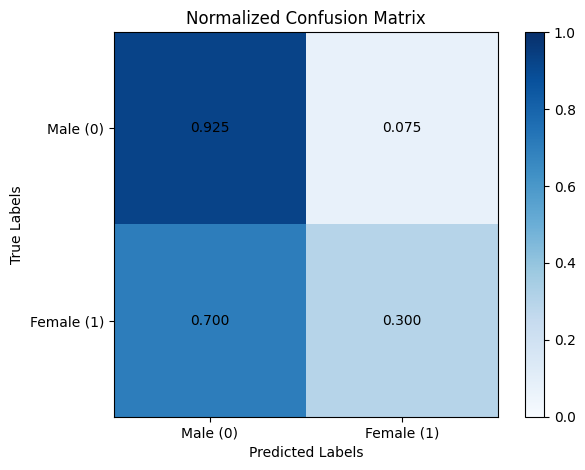

In [20]:
# visualize the splits for errors
actuals = test_predictions.detach().cpu().tolist()
expecteds = label_arr_test.detach().cpu().tolist()

# Initialize confusion matrix: [actual][predicted]
mtrx = [[0, 0],
      [0, 0]]

for actual, expected in zip(actuals, expecteds):

    mtrx[int(expected)][int(actual)] += 1

mtrx = np.array(mtrx)

# Normalize each row (i.e., per actual class)
mtrx_normal = (1.0* mtrx) / mtrx.sum(axis=1, keepdims=True)

fig, ax = plt.subplots()
im = ax.imshow(mtrx_normal, cmap='Blues', vmin=0, vmax=1)

# Labels, title and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Normalized Confusion Matrix')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Male (0)', 'Female (1)'])
ax.set_yticklabels(['Male (0)', 'Female (1)'])
for i in range(2):
    for j in range(2):
        value = mtrx_normal[i, j]
        ax.text(j, i, f'{value:.3f}', ha='center', va='center', color='black')

plt.colorbar(im)
plt.tight_layout()
plt.show()

In [21]:
tp = mtrx[1,1]
fp = mtrx[0,1]
fn = mtrx[1,0]

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.2250
Recall: 0.3000
F1 Score: 0.2571


Perhaps this is a bit better! We aren't always right, but now we have higher accuracy for the minority class.